In [111]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import mahalanobis
import torch
import pandas as pd
import seaborn as sns

In [238]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 150

In [294]:
df = pd.read_parquet('comp6v1_full_magnitudes.pq')
df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                    0.045506
mean_relative_range                                                    0.132286
n_atoms                                                                      20
mean_force_mag                [49.098209

In [288]:
error = df["size_weighted_energy_error"].corr(df["rms_force_error"])
print(f"Correlation between size_weighted_energy_error and rms_force_error: {error:.3f}")

error = df["size_weighted_energy_error"].corr(df["max_force_error"])
print(f"Correlation between size_weighted_energy_error and max_force_error: {error:.3f}")

error = df["size_weighted_energy_error"].corr(df["mean_abs_force_error"])
print(f"Correlation between size_weighted_energy_error and mean_abs_force_error: {error:.3f}")

Correlation between size_weighted_energy_error and rms_force_error: 0.413
Correlation between size_weighted_energy_error and max_force_error: 0.413
Correlation between size_weighted_energy_error and mean_abs_force_error: 0.413


In [295]:
import numpy as np

def compute_entropy(force_magnitudes):
    """
    Computes the entropy of force magnitudes for each atom across all models.
    Force magnitudes are binned into categories, and entropy is computed based on 
    the distribution of values in those bins.
    
    force_magnitudes: List or array of shape (8, N_atoms), containing the force magnitudes
    predicted by 8 models for each atom.
    
    Returns: A scalar entropy value representing the uncertainty in the predictions.
    """
    # Ensure force_magnitudes is a numpy array, and handle nested lists if needed
    force_magnitudes = np.array(force_magnitudes, dtype=object)  # Keep as object to handle nested lists
    
    # Flattening each atom's predictions across models into a single array
    flattened_forces = np.concatenate([np.array(f) for f in force_magnitudes], axis=0)  # Concatenate the individual atom's forces
    
    # Compute histogram (distribution) of force magnitudes, binning the values
    hist, bin_edges = np.histogram(flattened_forces, bins=10, density=True)

    # Remove any zero entries (log(0) is undefined)
    hist = hist[hist > 0]
    
    # Calculate entropy using the formula for Shannon entropy
    entropy = -np.sum(hist * np.log(hist))  # Shannon entropy: -sum(p * log(p))
    
    return entropy

# Apply function to each row in the dataframe to calculate entropy for each molecule
df["entropy_force_magnitudes"] = df["Members magnitudes"].apply(lambda x: compute_entropy(x))

# Display the entropy values for the first few molecules
df["entropy_force_magnitudes"]

0         0.497273
1         0.686086
2         0.539346
3         0.491832
4         0.596497
            ...   
101347    0.232547
101348    0.388779
101349    0.374441
101350    0.273470
101351    0.223284
Name: entropy_force_magnitudes, Length: 101352, dtype: float64

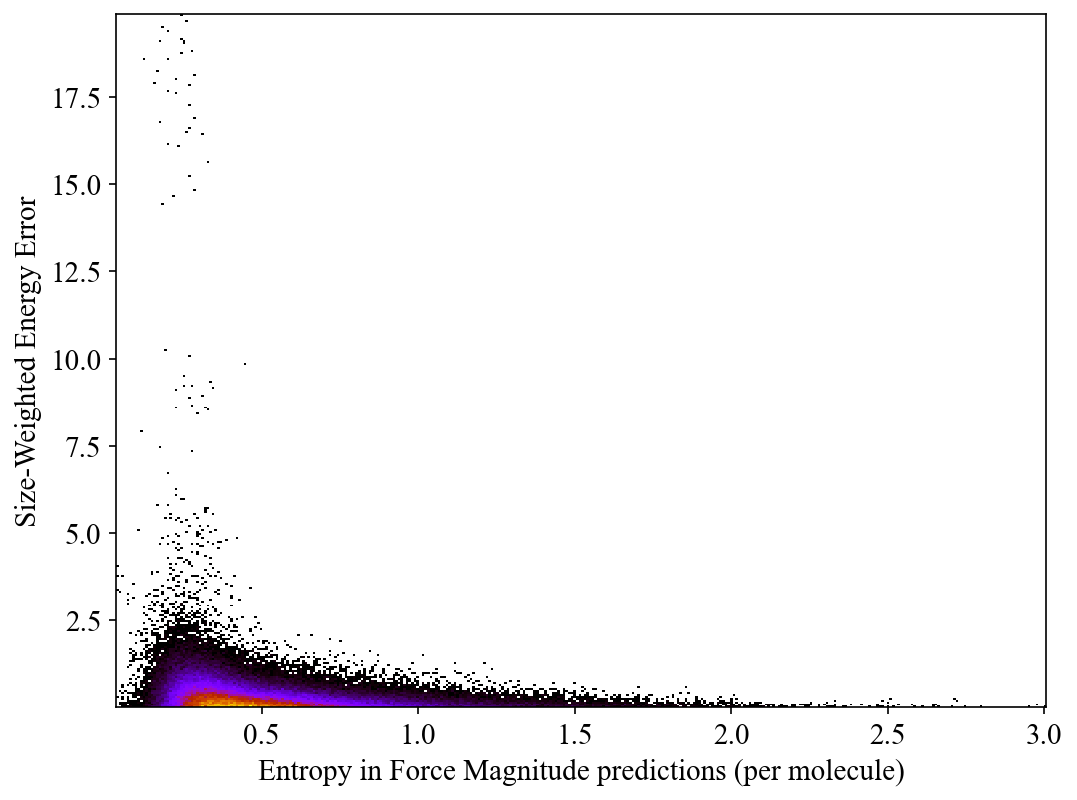

In [305]:
plt.hist2d(df['entropy_force_magnitudes'], df['size_weighted_energy_error'],
          bins=350, cmap='gnuplot', cmin=1)

plt.xlabel('Entropy in Force Magnitude predictions (per molecule)')
plt.ylabel('Size-Weighted Energy Error')
plt.savefig('figures/forces/fmag_entropy-vs-energy_error.png')
plt.show()

In [24]:
entropy_force_magnitudes = df["size_weighted_energy_error"].corr(df["entropy_force_magnitudes"])
print(f"Correlation between size_weighted_energy_error and entropy_force_magnitudes: {entropy_force_magnitudes:.3f}")

Correlation between size_weighted_energy_error and entropy_force_magnitudes: -0.224


In [114]:
df['Mean magnitudes'].iloc[0]

array([49.08607483, 26.80403137, 27.16452026, 37.56732941, 59.38204575,
       88.14095306, 22.43925667, 33.3119812 , 84.5486145 , 46.5952034 ,
       59.44159317, 24.25034142, 63.83255005, 10.38494587, 21.81581879,
       35.39805984, 50.50547409,  8.72707653, 11.76429939, 15.52490997])

In [307]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

def compute_mahalanobis_for_row(members_magnitudes, mean_magnitudes):
    # Make sure this stacks into shape (8, N_atoms)
    mem_array = np.vstack(members_magnitudes)      # (8, N_atoms)
    mean_array = np.array(mean_magnitudes)         # (N_atoms,)

    # Covariance matrix of shape (8, 8) across the 8 models
    # (rowvar=True => each row is a variable, so each row is one of the 8 model’s predictions)
    cov_matrix = np.cov(mem_array, rowvar=True)

    try:
        cov_matrix_inv = inv(cov_matrix)
    except np.linalg.LinAlgError:
        # If the covariance matrix is singular, return NaNs
        return [np.nan]*mem_array.shape[1]

    mahalanobis_distances = []
    for i in range(mem_array.shape[1]):
        # 8D vector (predictions from 8 models) for the i-th atom
        atom_forces = mem_array[:, i]

        # Scalar mean for this atom, replicated into an 8D vector
        # i.e., [mean_array[i], mean_array[i], ..., mean_array[i]]
        atom_mean_vec = np.full_like(atom_forces, mean_array[i])

        dist = mahalanobis(atom_forces, atom_mean_vec, cov_matrix_inv)
        mahalanobis_distances.append(dist)

    return mahalanobis_distances

In [308]:
import torch
import numpy as np

# Select a single row for debugging
sample_row = df.iloc[0]  # Change index as needed

mem = row["Members magnitudes"]
mean_ = row["Mean magnitudes"]

mem_array = np.vstack(mem)  # or np.stack(mem)
print(mem_array.shape)
print(np.array(mean_).shape)

compute_mahalanobis_for_row(mem, mean_)

(8, 20)
(20,)


[np.float64(1.2310835906392623),
 np.float64(4.0760824745427495),
 np.float64(2.509821847391906),
 np.float64(3.8826674062368274),
 np.float64(3.4949790981793574),
 np.float64(4.315006396063763),
 np.float64(3.0849455307880467),
 np.float64(4.395923010380452),
 np.float64(4.0141180959304545),
 np.float64(3.8730005296959997),
 np.float64(1.8796469068797912),
 np.float64(2.62917435519598),
 np.float64(2.2993491165060322),
 np.float64(1.9506210975425844),
 np.float64(2.047914324113036),
 np.float64(2.2241422507757203),
 np.float64(1.2792053997631803),
 np.float64(1.7159228558176771),
 np.float64(1.0781171998467847),
 np.float64(1.7920259072777645)]

In [309]:
df["mahalanobis_distances"] = df.apply(
    lambda row: compute_mahalanobis_for_row(row["Members magnitudes"], row["Mean magnitudes"]),
    axis=1
)

df['mahalanobis_distances'].iloc[-1]

/Users/nickterrel/.mamba/envs/figures/lib/python3.13/site-packages/scipy/spatial/distance.py:1139: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


[np.float64(3.859458635397092),
 np.float64(4.010169079246265),
 np.float64(2.9665061808591187),
 np.float64(3.9631990627982288),
 np.float64(2.7492494624743538),
 np.float64(2.3218918404378956),
 np.float64(3.228479027548533),
 np.float64(2.9789133905638367),
 np.float64(1.3054827177161017),
 np.float64(5.035189556714907),
 np.float64(3.6221521505251464),
 np.float64(4.068762315373129),
 np.float64(2.7096125221443166),
 np.float64(2.2363550479477925),
 np.float64(1.189122249854008),
 np.float64(0.672945994566702),
 np.float64(2.417805240054624),
 np.float64(2.747572260354358),
 np.float64(3.2919071323993534),
 np.float64(2.5487953504320244),
 np.float64(1.601728163468916),
 np.float64(0.9839045444777152),
 np.float64(1.5117343605082962),
 np.float64(1.8918574173266494),
 np.float64(2.121570264219324),
 np.float64(4.230910611774323),
 np.float64(3.48589432482685),
 np.float64(1.0024142677408219),
 np.float64(1.6269099815142773),
 np.float64(1.0435305731288724),
 np.float64(4.2054946517

In [310]:
df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                    0.045506
mean_relative_range                                                    0.132286
n_atoms                                                                      20
mean_force_mag                [49.098209

In [311]:
df["worst_atom_distance"] = df["mahalanobis_distances"].apply(np.max)

df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                    0.045506
mean_relative_range                                                    0.132286
n_atoms                                                                      20
mean_force_mag                [49.098209

In [312]:
force_correlation_error = df['size_weighted_energy_error'].corr(df['worst_atom_distance'])
print(f"Correlation between total energy error and force metric: {force_correlation_error:.3f}")

Correlation between total energy error and force metric: -0.002


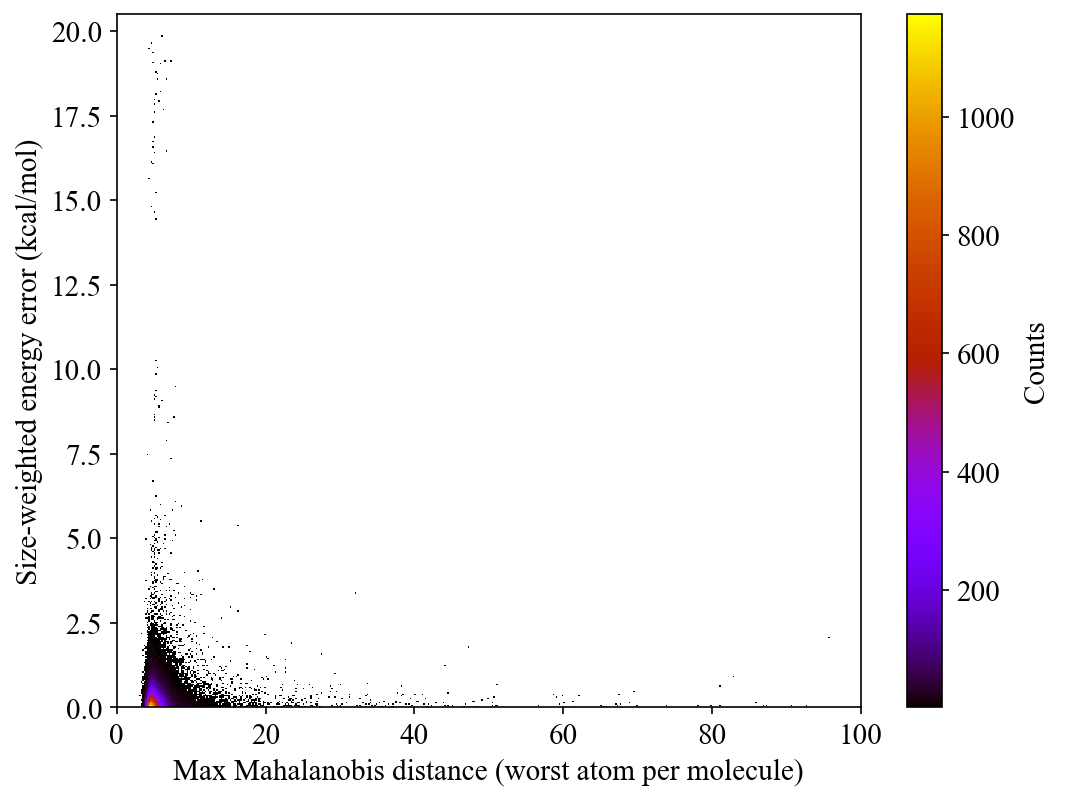

In [316]:
import matplotlib.pyplot as plt

plt.hist2d(
    x=df["worst_atom_distance"],
    y=df["size_weighted_energy_error"],
    bins=500, cmap="gnuplot", cmin=1,
    range=[[0,100], [0,20.5]]
)
plt.colorbar(label="Counts")
plt.xlabel("Max Mahalanobis distance (worst atom per molecule)")
plt.ylabel("Size-weighted energy error (kcal/mol)")
#plt.title("2D Histogram of Worst Atom Distance vs. Energy Error")
plt.savefig('figures/forces/max_maha_dist-vs-energy_error.png')
plt.show()

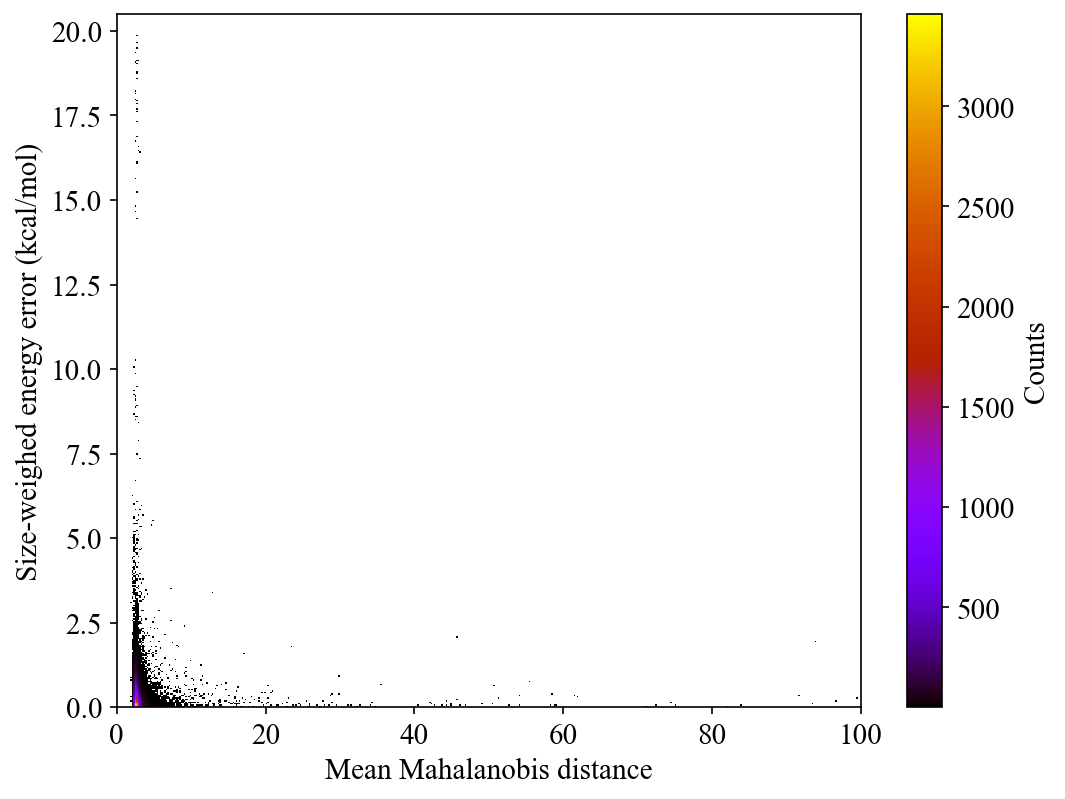

In [317]:
df["mean_mahalanobis_distance"] = df["mahalanobis_distances"].apply(np.mean)

plt.hist2d(
    x=df["mean_mahalanobis_distance"],
    y=df["size_weighted_energy_error"],
    bins=500, cmap="gnuplot", cmin=1,
    range=[[0,100], [0,20.5]]
)
plt.colorbar(label="Counts")
plt.xlabel("Mean Mahalanobis distance")
plt.ylabel("Size-weighed energy error (kcal/mol)")
#plt.title("2D Histogram of Worst Atom Distance vs. Energy Error")
plt.savefig('figures/forces/mean_maha_dist-vs-energy_error.png')
plt.show()

/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_18502/3100592888.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


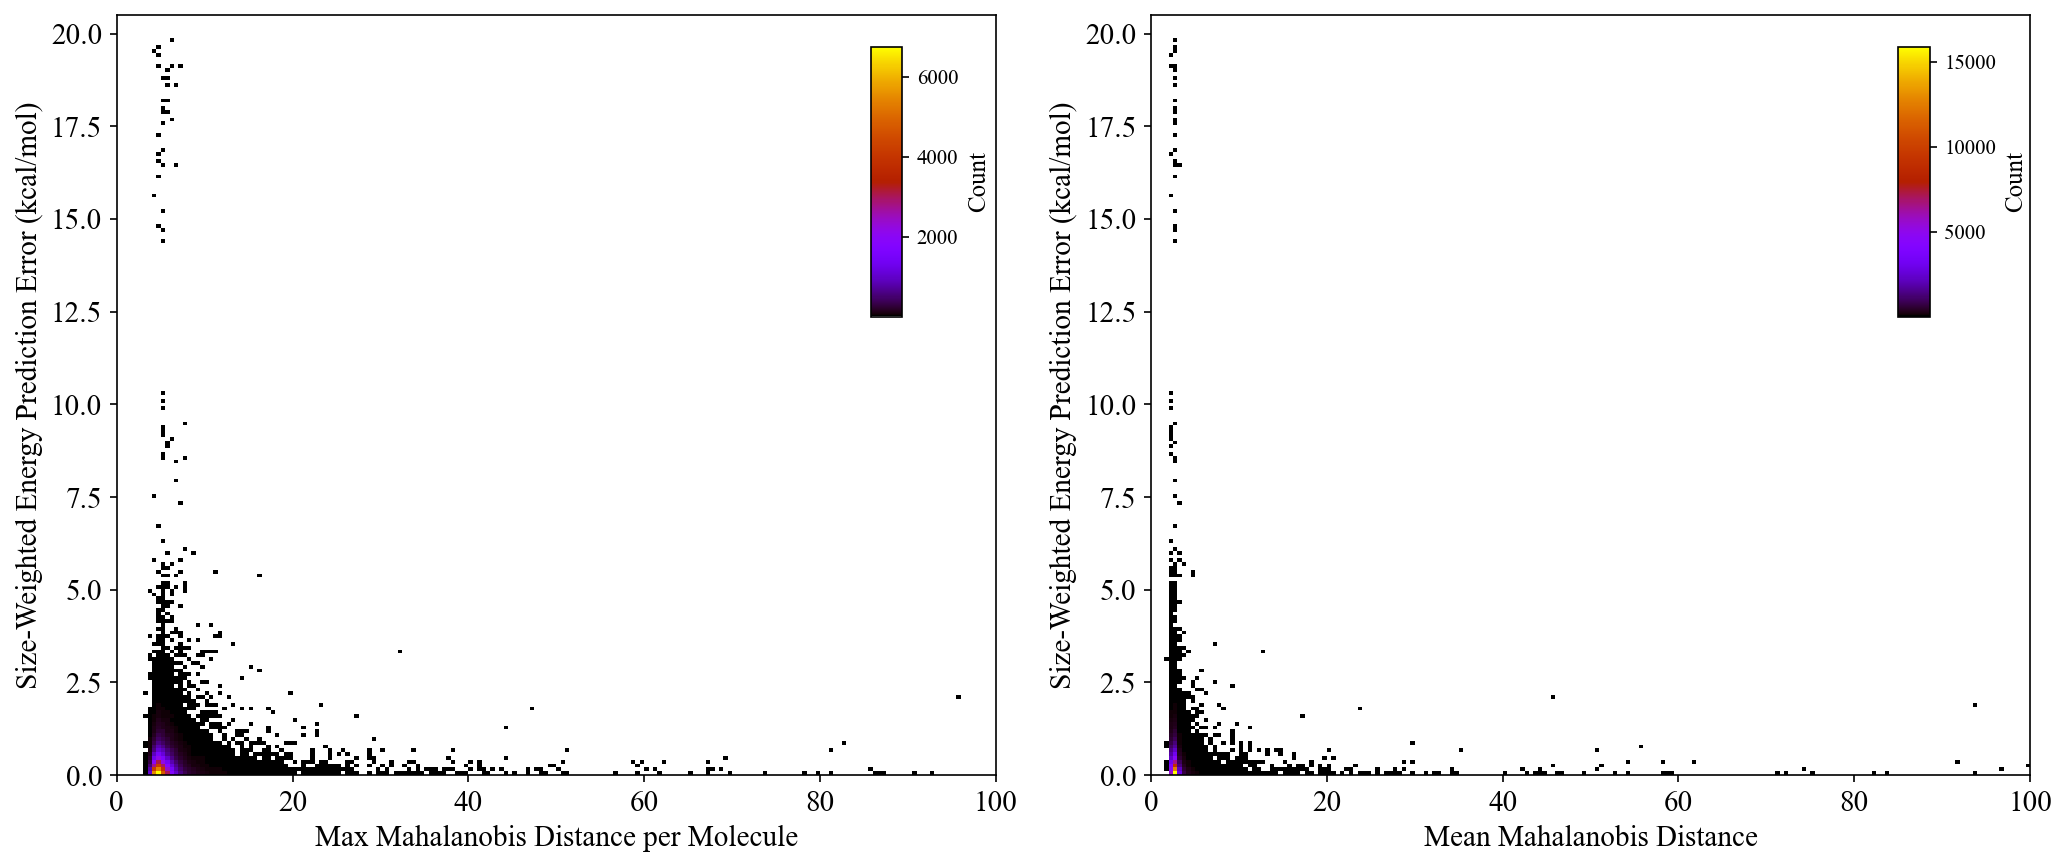

In [378]:
import numpy as np
import matplotlib.pyplot as plt

x_max_maha = df["worst_atom_distance"]
x_mean_maha = df["mean_mahalanobis_distance"]
y_error = df["size_weighted_energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Max Mahalanobis distance vs. Energy Error
hb1 = axes[0].hist2d(x_max_maha, y_error, bins=200, cmap="gnuplot", cmin=1, range=[[0, 100], [0, 20.5]])
axes[0].set_xlabel("Max Mahalanobis Distance per Molecule")
axes[0].set_ylabel("Size-Weighted Energy Prediction Error (kcal/mol)")

# Add small color bar in top-right corner of first subplot
cbar_ax1 = fig.add_axes([0.4225, 0.63, 0.015, 0.3])  # [x-pos, y-pos, width, height]
cbar1 = fig.colorbar(hb1[3], cax=cbar_ax1)
cbar1.set_label("Count", fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# Second subplot: Mean Mahalanobis distance vs. Energy Error
hb2 = axes[1].hist2d(x_mean_maha, y_error, bins=200, cmap="gnuplot", cmin=1, range=[[0, 100], [0, 20.5]])
axes[1].set_xlabel("Mean Mahalanobis Distance")
axes[1].set_ylabel("Size-Weighted Energy Prediction Error (kcal/mol)")

# Add small color bar in top-right corner of second subplot
cbar_ax2 = fig.add_axes([0.9118, 0.63, 0.015, 0.3])  # [x-pos, y-pos, width, height]
cbar2 = fig.colorbar(hb2[3], cax=cbar_ax2)
cbar2.set_label("Count", fontsize=12)
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("./figures/forces/2xr_comp6v1_mahalanobis-uncertainty-vs-energy.png")
plt.show()

In [216]:
low_threshold = df["energy_error"].quantile(0.05)
high_threshold = df["energy_error"].quantile(0.95)

lowest_5p_df = df[df["energy_error"] <= low_threshold].copy()
highest_5p_df = df[df["energy_error"] >= high_threshold].copy()

print("Lowest error subset size:", len(lowest_5p_df))
print("Highest error subset size:", len(highest_5p_df))

print("Average QBC from low-error subset:", lowest_5p_df['energy_qbc'].mean())
print("Average QBC from high-error subset:", highest_5p_df['energy_qbc'].mean())

print("Average error from low-error subset:", lowest_5p_df['energy_error'].mean())
print("Average error from high-error subset:", highest_5p_df['energy_error'].mean())

print(lowest_5p_df['rms_force_error'].mean())
print(highest_5p_df['rms_force_error'].mean())

Lowest error subset size: 5068
Highest error subset size: 5068
Average QBC from low-error subset: 0.18838658676596484
Average QBC from high-error subset: 0.5937054747340482
Average error from low-error subset: 0.043739672494861125
Average error from high-error subset: 8.862463569158038
3.2449315810648605
7.780554329021696


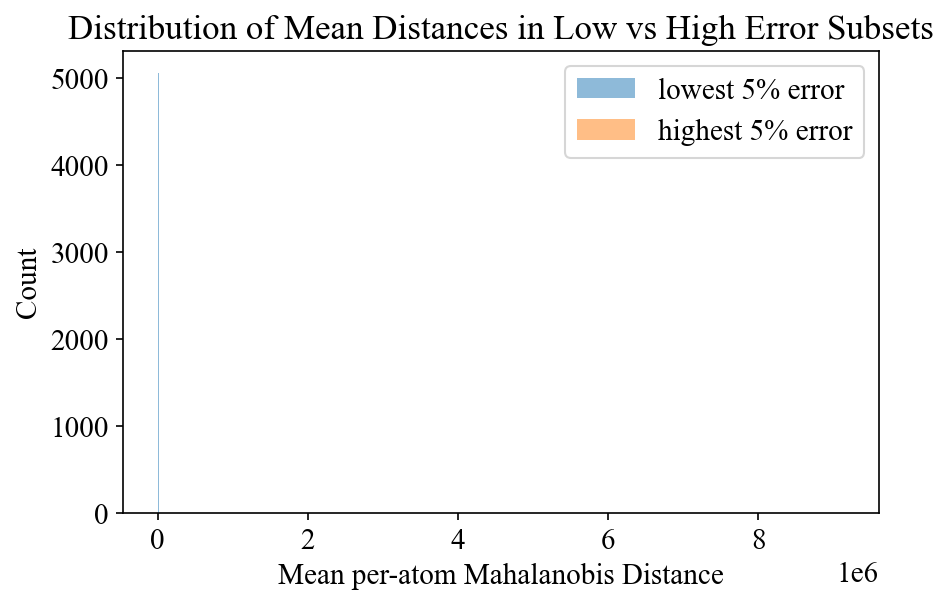

In [214]:
def get_bad_atom_info(mahal_distances, species_list, percentile=0.9):
    cutoff = np.quantile(mahal_distances, percentile)
    return [
        {"atom_idx": i, "distance": dist, "species": species_list[i]}
        for i, dist in enumerate(mahal_distances)
        if dist >= cutoff
    ]

highest_5p_df["bad_atom_info"] = highest_5p_df.apply(
    lambda row: get_bad_atom_info(row["mahalanobis_distances"], row["species"], 0.9),
    axis=1
)


lowest_5p_df["mean_maha"] = lowest_5p_df["mahalanobis_distances"].apply(np.mean)
highest_5p_df["mean_maha"] = highest_5p_df["mahalanobis_distances"].apply(np.mean)

plt.hist(lowest_5p_df["mean_maha"], bins=50, alpha=0.5, label="lowest 5% error")
plt.hist(highest_5p_df["mean_maha"], bins=50, alpha=0.5, label="highest 5% error")
plt.xlabel("Mean per-atom Mahalanobis Distance")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Mean Distances in Low vs High Error Subsets")
plt.show()

In [324]:
def compute_entropy(force_magnitudes):
    """
    Computes the entropy of force magnitudes for each atom across all models.
    Force magnitudes are binned into categories, and entropy is computed based on 
    the distribution of values in those bins.
    
    force_magnitudes: List or array of shape (8,) containing the force magnitudes
    predicted by 8 models for a single atom.
    
    Returns: A scalar entropy value representing the uncertainty in the predictions for that atom.
    """
    # Ensure force_magnitudes is a numpy array
    force_magnitudes = np.array(force_magnitudes, dtype=float)  # Convert to float

    # Compute histogram (distribution) of force magnitudes, binning the values
    hist, bin_edges = np.histogram(force_magnitudes, bins=20, density=True)

    # Remove any zero entries (log(0) is undefined)
    hist = hist[hist > 0]
    
    # Calculate entropy using the formula for Shannon entropy
    entropy = -np.sum(hist * np.log(hist))  # Shannon entropy: -sum(p * log(p))
    
    return entropy

# Apply function to each atom in the dataframe to calculate entropy for each atom's force magnitudes
df["entropy_force_magnitudes"] = df["Members magnitudes"].apply(
    lambda x: [compute_entropy(atom_forces) for atom_forces in x]
)

# Display the entropy values for the first molecule's atoms
print(df["entropy_force_magnitudes"].iloc[0])  # This will give entropy per atom for the first molecule

[np.float64(0.906295361055581), np.float64(0.9394907508801126), np.float64(0.9137894829557117), np.float64(0.9740147649679689), np.float64(0.9340610900877006), np.float64(0.9419475712712774), np.float64(0.9519542102898205), np.float64(0.9896467459259868)]


/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_18502/1067530114.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


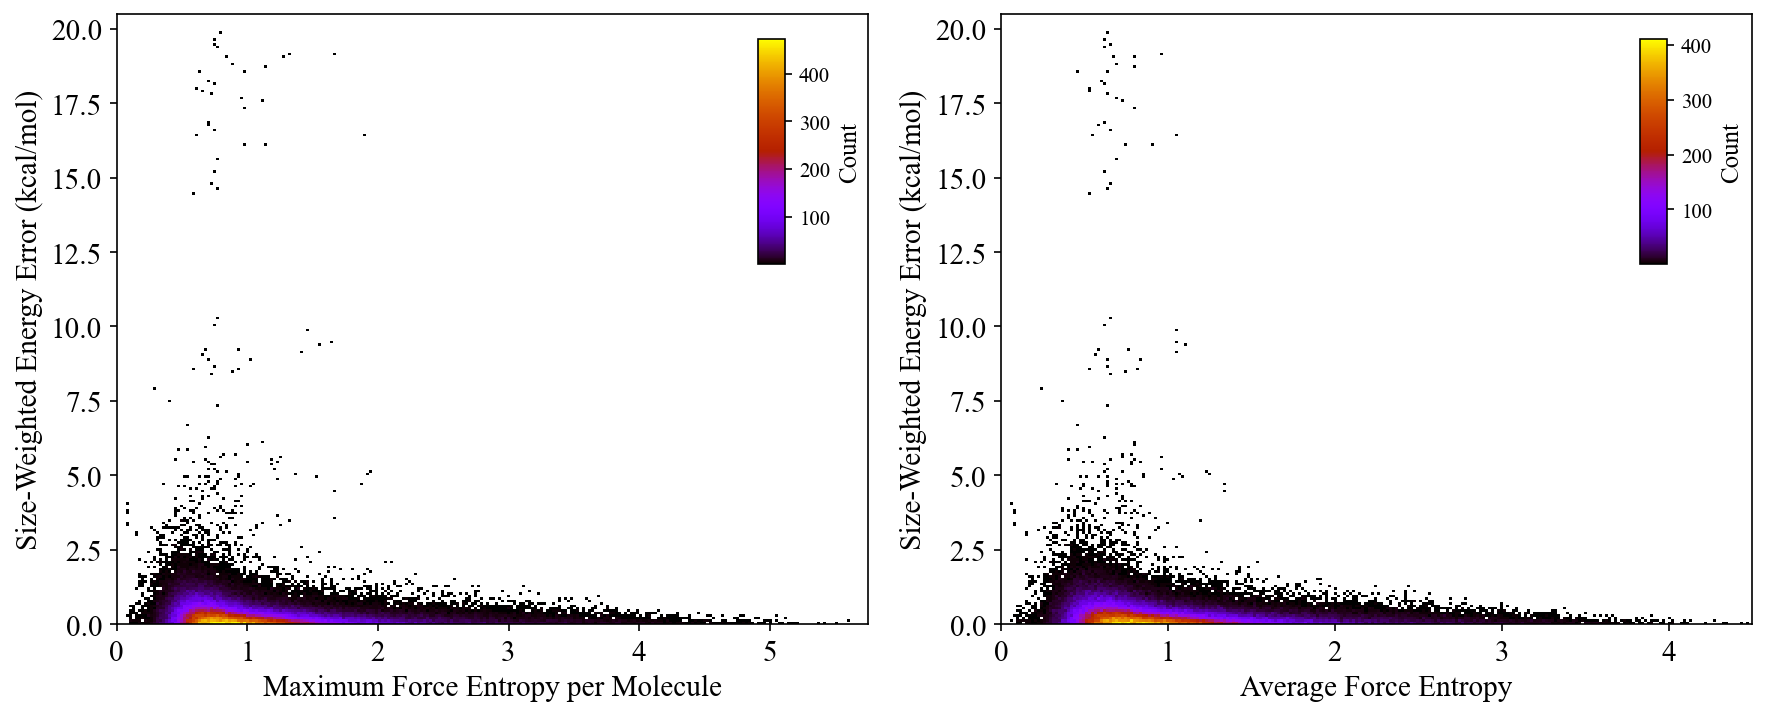

In [377]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate maximum and average entropy per molecule
df["max_entropy_force_magnitudes"] = df["entropy_force_magnitudes"].apply(lambda x: max(x))  # Maximum entropy per molecule
df["avg_entropy_force_magnitudes"] = df["entropy_force_magnitudes"].apply(lambda x: np.mean(x))  # Average entropy per molecule

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Max entropy per molecule
hb1 = axes[0].hist2d(df['max_entropy_force_magnitudes'], df['size_weighted_energy_error'], 
                      bins=250, cmap='gnuplot', cmin=1, range=[[0, 5.75], [0, 20.5]])
axes[0].set_xlabel('Maximum Force Entropy per Molecule')
axes[0].set_ylabel('Size-Weighted Energy Error (kcal/mol)')

# Add small color bar in top-right corner of first subplot
cbar_ax1 = fig.add_axes([0.43, 0.625, 0.015, 0.3])  # [x-pos, y-pos, width, height]
cbar1 = fig.colorbar(hb1[3], cax=cbar_ax1)
cbar1.set_label("Count", fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# Second subplot: Avg entropy per molecule
hb2 = axes[1].hist2d(df['avg_entropy_force_magnitudes'], df['size_weighted_energy_error'], 
                      bins=250, cmap='gnuplot', cmin=1, range=[[0, 4.5], [0, 20.5]])
axes[1].set_xlabel('Average Force Entropy')
axes[1].set_ylabel('Size-Weighted Energy Error (kcal/mol)')

# Add small color bar in top-right corner of second subplot
cbar_ax2 = fig.add_axes([0.92, 0.625, 0.015, 0.3])  # Adjust placement
cbar2 = fig.colorbar(hb2[3], cax=cbar_ax2)
cbar2.set_label("Count", fontsize=12)
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('./figures/forces/force_entropy-vs-energy.png')
plt.show()

In [328]:
correlation_max_entropy = df["size_weighted_energy_error"].corr(df["max_entropy_force_magnitudes"])
correlation_avg_entropy = df['size_weighted_energy_error'].corr(df['avg_entropy_force_magnitudes'])
print(f"Correlation between size_weighted_energy_error and correlation_max_entropy: {correlation_max_entropy:.3f}")
print(f"Correlation between size_weighted_energy_error and correlation_avg_entropy: {correlation_avg_entropy:.3f}")

Correlation between size_weighted_energy_error and correlation_max_entropy: -0.180
Correlation between size_weighted_energy_error and correlation_avg_entropy: -0.199


In [329]:
correlation_rms_force_error = df["size_weighted_energy_error"].corr(df["rms_force_error"])
correlation_max_force_error = df["size_weighted_energy_error"].corr(df["max_force_error"])
correlation_mean_abs_force_error = df["size_weighted_energy_error"].corr(df["mean_abs_force_error"])
print(f"Correlation between size_weighted_energy_error and correlation_rms_force_error: {correlation_rms_force_error:.3f}")
print(f"Correlation between size_weighted_energy_error and correlation_max_force_error: {correlation_max_force_error:.3f}")
print(f"Correlation between size_weighted_energy_error and correlation_mean_abs_force_error: {correlation_mean_abs_force_error:.3f}")

Correlation between size_weighted_energy_error and correlation_rms_force_error: 0.463
Correlation between size_weighted_energy_error and correlation_max_force_error: 0.425
Correlation between size_weighted_energy_error and correlation_mean_abs_force_error: 0.473


In [330]:
correlation_mean_rel_stdev = df["size_weighted_energy_error"].corr(df["mean_relative_stdev"])
correlation_mean_rel_range = df["size_weighted_energy_error"].corr(df["mean_relative_range"])
print(f"Correlation between size_weighted_energy_error and correlation_mean_rel_stdev: {correlation_mean_rel_stdev:.3f}")
print(f"Correlation between size_weighted_energy_error and correlation_mean_rel_range: {correlation_mean_rel_range:.3f}")

Correlation between size_weighted_energy_error and correlation_mean_rel_stdev: 0.082
Correlation between size_weighted_energy_error and correlation_mean_rel_range: 0.083


High-error atom threshold (top 10.0% of deviations): 10.0996
Maximum observed deviation in dataset: 704.6770


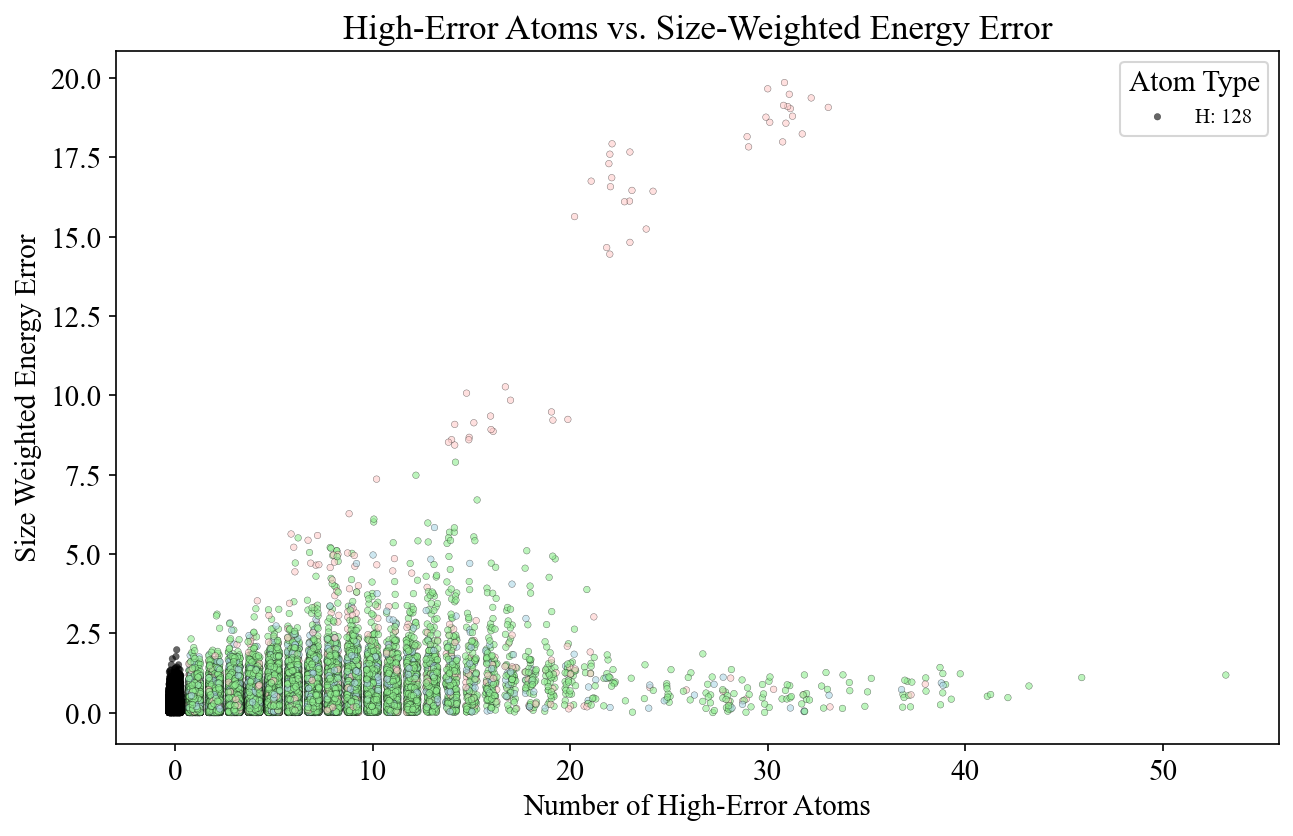

In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The color mapping for species
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}

def compute_max_force_magnitude_deviation(force_magnitudes, mean_magnitudes):
    """
    Compute the maximum deviation from the mean force magnitude for each atom across all models.
    """
    force_magnitudes = np.array([np.array(fm) for fm in force_magnitudes])  # Convert the list of arrays into a 2D array
    mean_magnitudes = np.array(mean_magnitudes)

    # Tile mean_magnitudes to match the shape of force_magnitudes (8, N_atoms)
    mean_magnitudes_tiled = np.tile(mean_magnitudes, (8, 1))  # Shape: (8, N_atoms)

    # Compute the deviation for each model's prediction from the mean for each atom
    deviation = np.abs(force_magnitudes - mean_magnitudes_tiled)  # Shape: (8, N_atoms)

    # Compute the maximum deviation for each atom (across the models)
    max_deviation = np.max(deviation, axis=0)  # Shape: (N_atoms,)

    return max_deviation

# Apply the function to compute the max deviation per atom for each row
df["max_deviation_per_atom"] = df.apply(
    lambda row: compute_max_force_magnitude_deviation(
        row["Members magnitudes"], row["Mean magnitudes"]
    ),
    axis=1
)

#print(f"Correlation of max deviation with size-weighted energy error: {df['size_weighted_energy_error'].corr(df['max_deviation_per_atom'])}")

# Compute the high-error threshold (top 10% of atoms)
top_percentile = 0.1  # Top 10% of atoms
threshold = np.percentile(df["max_deviation_per_atom"].explode(), 100 * (1 - top_percentile))

# Get the observed max deviation across all atoms
observed_max_deviation = df["max_deviation_per_atom"].explode().max()

# Print out both the threshold and the maximum observed deviation
print(f"High-error atom threshold (top {top_percentile*100}% of deviations): {threshold:.4f}")
print(f"Maximum observed deviation in dataset: {observed_max_deviation:.4f}")

# Create a column to mark high-error atoms for each molecule
df["high_error_atoms"] = df["max_deviation_per_atom"].apply(
    lambda x: (x > threshold).sum()  # Count number of high-error atoms for each molecule
)

# For color mapping: assign a color to each high-error atom based on the species
def map_species_to_color(row):
    species = row["species"]  # List of species for the molecule
    high_error_indices = np.where(row["max_deviation_per_atom"] > threshold)[0]  # Get high-error atom indices
    colors = [atom_types_colors.get(species[i], ("Unknown", "#000000"))[1] for i in high_error_indices]
    return colors

df["high_error_species_colors"] = df.apply(map_species_to_color, axis=1)

# Aggregate the colors for each molecule (e.g., take the color of the first high-error atom)
def aggregate_colors(colors):
    if colors:
        return colors[0]  # Select the first high-error atom's color
    return "#000000"  # Default color if no high-error atoms are present

df["aggregated_colors"] = df["high_error_species_colors"].apply(aggregate_colors)

# Now we have a single color per molecule for the scatter plot
colors = df["aggregated_colors"].tolist()

# **Apply Jitter** to avoid overlap at x = 0
jitter = np.random.uniform(-0.3, 0.3, size=len(df))  # Small random shift

# Scatter Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df["high_error_atoms"] + jitter, df["size_weighted_energy_error"], 
                      alpha=0.6, marker='o', s=10, c=colors, edgecolors="k", linewidth=0.2)

# **Legend Fix: Count occurrences per species**
species_counts = {species: 0 for species in atom_types_colors.keys()}
for color in colors:
    species = next((s for s, (_, c) in atom_types_colors.items() if c == color), None)
    if species is not None:
        species_counts[species] += 1

# **Sort legend entries by species type**
legend_labels = [f"{atom_types_colors[species][0]}: {count}" for species, count in sorted(species_counts.items())]

# **Add legend to the plot**
plt.legend(legend_labels, title="Atom Type", loc="upper right", fontsize=10, frameon=True)

plt.xlabel("Number of High-Error Atoms")
plt.ylabel("Size Weighted Energy Error")
plt.title("High-Error Atoms vs. Size-Weighted Energy Error")

plt.show()

In [331]:
row = df.iloc[0]

# Extract "Members magnitudes" and "Mean magnitudes" for the first molecule
force_magnitudes = row["Members magnitudes"]
mean_magnitudes = row["Mean magnitudes"]

# Print the values and shapes for debugging
print("Force Magnitudes (Members magnitudes) for molecule 0:", force_magnitudes)
print("Mean Magnitudes for molecule 0:", mean_magnitudes)

print("Force Magnitudes Shape:", np.array(force_magnitudes).shape)  # Expected (8, N_atoms)
print("Mean Magnitudes Shape:", np.array(mean_magnitudes).shape)    # Expected (N_atoms,)

# Ensure force_magnitudes is a 2D array with shape (8, N_atoms)
force_magnitudes = np.array([np.array(fm) for fm in force_magnitudes])  # Convert list of arrays to 2D array
mean_magnitudes = np.array(mean_magnitudes)  # Convert to np array if not already

# Debug: Check the shapes again
print("Reshaped Force Magnitudes Shape:", force_magnitudes.shape)
print("Mean Magnitudes Shape:", mean_magnitudes.shape)

# Tile the mean_magnitudes to match the shape of force_magnitudes (8, N_atoms)
mean_magnitudes_tiled = np.tile(mean_magnitudes, (8, 1))  # Shape: (8, N_atoms)

# Compute the deviation for each model's prediction from the mean for each atom
deviation = np.abs(force_magnitudes - mean_magnitudes_tiled)  # Shape: (8, N_atoms)

# Compute the maximum deviation for each atom (across the models)
max_deviation = np.max(deviation, axis=0)  # Shape: (N_atoms,)

# Debug: Print the max deviation for the first few atoms
print("Max deviation for each atom:", max_deviation)

# Now compute high-error atoms for this single molecule
top_percentile = 0.1  # Top 10% of atoms
threshold = np.percentile(max_deviation, 100 * (1 - top_percentile))

# Create a mask for high-error atoms
high_error_atoms = (max_deviation > threshold).sum()  # Count number of high-error atoms

print("Number of High-Error Atoms:", high_error_atoms)

# Now that we know it works for this single molecule, we can apply it to the whole DataFrame

Force Magnitudes (Members magnitudes) for molecule 0: [array([48.13784027, 25.05382347, 28.62235832, 35.99450684, 61.00183487,
        86.1914978 , 22.08209038, 36.09263992, 84.98846436, 48.35126877,
        60.54161835, 25.71699333, 64.15447998,  9.92870808, 22.75090408,
        35.44433212, 50.1245079 ,  9.57989502, 12.14378262, 15.44796371])
 array([48.48882294, 23.49107361, 26.38538742, 36.21721268, 56.82402039,
        88.308815  , 21.99638557, 31.74097824, 82.2425766 , 46.07516861,
        58.65075302, 23.68323708, 62.50780487, 11.25000763, 21.42623138,
        34.07884216, 50.99204254,  9.06229496, 11.66537476, 14.90755367])
 array([49.31049347, 29.86948776, 28.01010895, 40.31958771, 58.93669128,
        93.44280243, 23.19874001, 37.28155899, 87.10090637, 49.74901199,
        59.64148331, 25.30400276, 64.83262634,  9.38201141, 21.49379539,
        35.44242859, 50.67279816,  8.57974052, 12.25435543, 15.57797718])
 array([48.40787506, 26.42630196, 27.35829926, 32.95693207, 59.3320

In [332]:
# Find the indices of the high-error atoms
high_error_indices = np.where(max_deviation > threshold)[0]

# Debug: print the indices of high-error atoms
print("Indices of High-Error Atoms:", high_error_indices)

# Assuming the 'species' column exists in the DataFrame
species = row["species"]  # Extract the species for the current row

# Get the species for the high-error atoms
high_error_species = [species[i] for i in high_error_indices]

# Debug: print the species of high-error atoms
print("Species of High-Error Atoms:", high_error_species)

Indices of High-Error Atoms: [3 5]
Species of High-Error Atoms: [np.int64(6), np.int64(6)]


95th percentile threshold: 0.9999988210201262


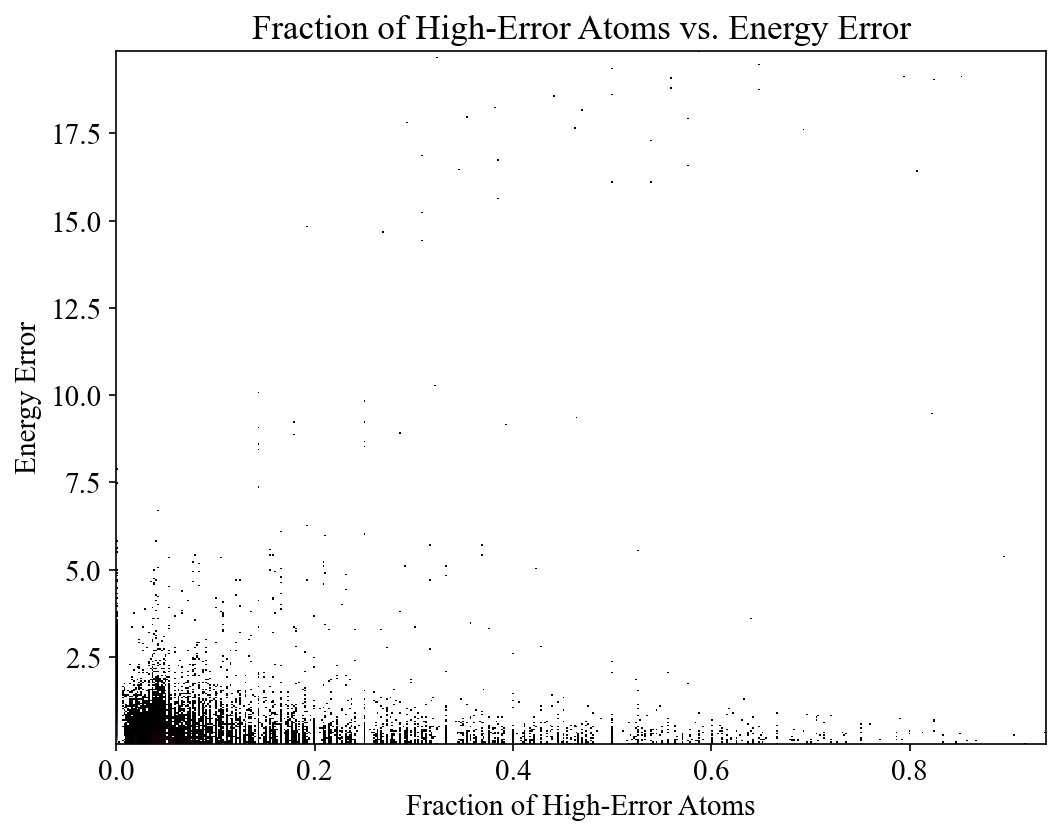

                     frac_high_err_atoms  energy_error
frac_high_err_atoms             1.000000      0.094185
energy_error                    0.094185      1.000000


In [334]:
import numpy as np

# Flatten all atoms from all molecules into a single 1D list
all_ranges = []
for row_list in df["force_relative_range"]:
    all_ranges.extend(row_list)

# 95th percentile threshold
threshold_95 = np.quantile(all_ranges, 0.98)
print("95th percentile threshold:", threshold_95)

def count_high_err_atoms(force_list, threshold):
    return sum(f >= threshold for f in force_list)

df["num_high_err_atoms"] = df["force_relative_range"].apply(
    lambda frange: count_high_err_atoms(frange, threshold_95)
)
df["frac_high_err_atoms"] = df.apply(
    lambda row: row["num_high_err_atoms"] / len(row["force_relative_range"]),
    axis=1
)

import matplotlib.pyplot as plt

# Simple scatter
plt.hist2d(df["frac_high_err_atoms"], df["size_weighted_energy_error"], 
           bins=500, cmap='gnuplot', cmin=1)
plt.xlabel("Fraction of High-Error Atoms")
plt.ylabel("Energy Error")
plt.title("Fraction of High-Error Atoms vs. Energy Error")
plt.show()

# Or compute correlation
corr_matrix = df[["frac_high_err_atoms", "energy_error"]].corr(method="pearson")
print(corr_matrix)